In [992]:
import math
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import os

#### Let's read in the necessary files.

Monthly data from 1939-1956 on commercial construction, copied manually from the Bureau of Labor Statistics Report "Construction Volume and Costs, 1915-1956: A Historical Supplement to Construction Review", pp. 14-25.

Original report accessible here: https://www.google.com/books/edition/Construction_Volume_and_Costs_1915_1956/dwhG59SWcGwC?hl=en

Monthly. In "1947-1949 dollars", according to the report.

In [993]:
BLS_1939_1956 = pd.read_csv('BLS_Construction_Volume_1915-1956.csv')

Annual data from 1915-1964 on commercial construction, copied manually from the US Business and Defense Services Administration report "Construction Statistics 1915-1964: A supplement to construction review", pages 2 and 4.

Original report accessible here: 
https://www.google.com/books/edition/Construction_Statistics_1915_1964_a_Supp/-4w0pLkVmGMC?hl=en

Annually. Not updated for inflation, so we will have to do that.

In [994]:
Commerce_1915_1964 = pd.read_csv("Dept_Commerce_1915-1964.csv")

US Census "Construction Put-in Place" Data, from here: https://www.census.gov/construction/c30/oldtc.html

Note that the field "Other Commercial" includes office from 1964-1971

Monthly. Not adjusted for inflation.

In [995]:
Census_1964_2002 = pd.read_csv('US_Census_1964_2002.csv')

US Census "Construction Put-in Place" Data, Jan 1993 - September 2020, from here: https://www.census.gov/construction/c30/historical_data.html

Monthly. Not adjusted for inflation.

In [996]:
Census_1993_2020 = pd.read_csv('US_Census_1993-2020.csv')

For the sake of consistency, let's convert everything into 2019 dollars and use that throughout.

#### Combining the data

Ok, so now we have a series of datasets that together represent all commercial construction in the United States from 1915 to 2020. These datasets do not directly map on to one another: they dollar amounts reported in each represent prices from different eras, so each dataset will have to be adjusted for inflation for an apples-to-apples comparison to be possible. 

Further, some of these datasets represent month-by-month data, and others represent annual data. The month-by-month data is useful as it allows to detect seasonal variation. We should try to detect this seasonal variation so that we can impute reasonable estimates of the month-by-month values for those eras for which only annual data is possible.

Further, there is some missing data: specifically, for some reason there are no office construction numbers between 1964-1971, only values for "total commercial construction". But if we know how office construction relates to total commercial construction (and varies with respect to it seasonally) then we can make a reasonable estimate of office construction for these years. 

#### Step 1: Combine 1964-2002 and 1993-2020 data series.

Since both of these are in constant 2003 dollars, and since both tally construction statistics monthly, combining these two is relatively straightforward.

Let's get just the office and date arrays from these two datasets.

In [997]:
office_1993_2020 = Census_1993_2020[['Date','Office','Other commercial']]
office_1964_2002 = Census_1964_2002[['Month','OFFICE','OTHER COMMERCIAL']]

In [998]:
office_1993_2020 = office_1993_2020.rename(columns={'Date':'Month'})
office_1964_2002 = office_1964_2002.rename(columns={'OFFICE':'Office','OTHER COMMERCIAL':'Other commercial'})

#Also for some reason office is stored as string in the 1993-2020 df
office_1993_2020['Office'] = office_1993_2020['Office'].str.replace(',', '').astype(float)
office_1993_2020['Other commercial'] = office_1993_2020['Other commercial'].str.replace(',', '').astype(float)
office_1964_2002['Office'] = office_1964_2002['Office'].astype(float)
office_1964_2002['Other commercial'] = office_1964_2002['Other commercial'].astype(float)

In [999]:
#Let's just adjust the dates a bit before converting them to datetime
format_str = '%m/%d/%Y'

new_1993_2020_dates = []
for i in office_1993_2020["Month"]:
    if i[-2] == '9':
        new_date = i[:-2]+'19'+i[-2]+i[-1]
    else:
        new_date = i[:-2]+'20'+i[-2]+i[-1]
        
    new_date = datetime.strptime(new_date, format_str)
    new_1993_2020_dates.append(new_date)
    
#Let's just adjust the dates a bit before converting them to datetime
new_1964_2002_dates = []
for i in office_1964_2002["Month"]:
    if i[-2] == '0':
        new_date = i[:-2]+'20'+i[-2]+i[-1]
    else:
        new_date = i[:-2]+'19'+i[-2]+i[-1]
        
    new_date = datetime.strptime(new_date, format_str)
    new_1964_2002_dates.append(new_date)

office_1993_2020['Month'] = new_1993_2020_dates
office_1964_2002['Month'] = new_1964_2002_dates

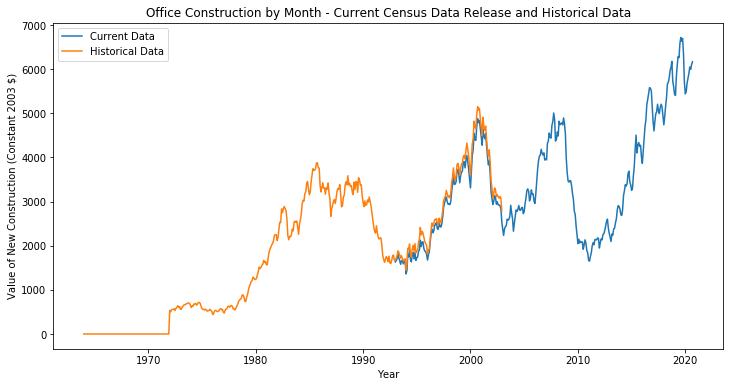

In [1000]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(office_1993_2020['Month'],office_1993_2020['Office'],label='Current Data')
ax.plot(office_1964_2002['Month'],office_1964_2002['Office'],label='Historical Data')

ax.set_ylabel('Value of New Construction (Constant 2003 $)')
ax.set_xlabel('Year')
ax.set_title('Office Construction by Month - Current Census Data Release and Historical Data')
    
ax.legend()
plt.show()

Cool! They look pretty aligned. We are safe to combine. Since the 1993-2020 is the more recent dataset, let's override the older dataset with the values from this dataset and combine them. 

In [1001]:
office_1964_2002 = office_1964_2002[office_1964_2002['Month'] < datetime.strptime("01/01/1993", format_str)]

In [1002]:
census_dfs = [office_1964_2002,office_1993_2020]
census_df = pd.concat(census_dfs)
census_df = census_df.reset_index()
census_df = census_df.drop(['index'], axis=1)

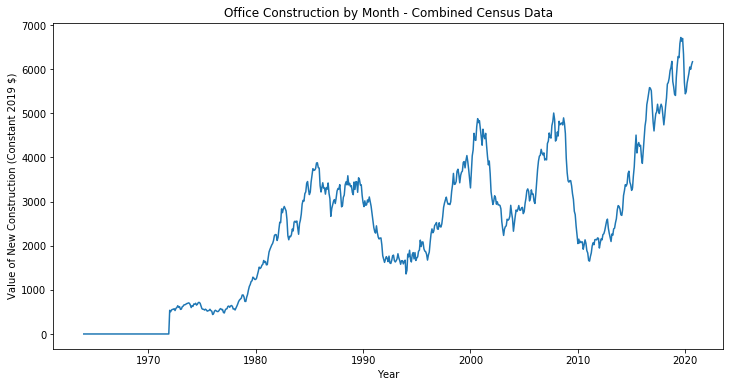

In [1003]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(census_df['Month'],census_df['Office'])

ax.set_ylabel('Value of New Construction (Constant 2019 $)')
ax.set_xlabel('Year')
ax.set_title('Office Construction by Month - Combined Census Data')
plt.show()

Great! Now, let's use the data that was in the original 1964-2002 file to impute the volume of office construction between 1964 and 1971.

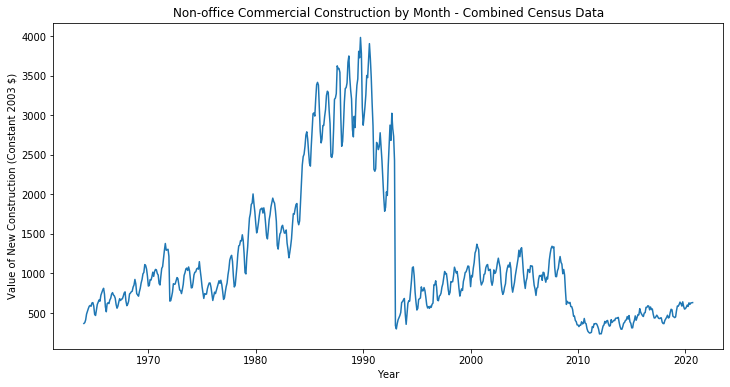

In [1004]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(census_df['Month'],census_df['Other commercial'])

ax.set_ylabel('Value of New Construction (Constant 2003 $)')
ax.set_xlabel('Year')
ax.set_title('Non-office Commercial Construction by Month - Combined Census Data')
plt.show()

Notice that non-office commercial property appears to be defined less by long cyclical fluctuations and more by seasonal trends. Let's look at how office construction compares to commercial construction for the period of the early 1970's for which we have data.

In [1005]:
census_df['Total commercial'] = census_df['Office'] + census_df['Other commercial']
census_df['Office portion'] = census_df['Office']/census_df['Total commercial']

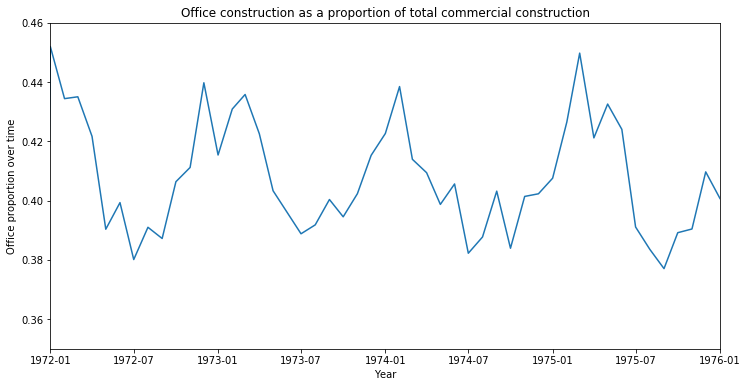

In [1006]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(census_df['Month'],census_df['Office portion'])
ax.set_ylabel('Office proportion over time')
ax.set_xlabel('Year')
ax.set_title('Office construction as a proportion of total commercial construction')

year_begin = datetime.strptime("01/01/1972", format_str)
year_end = datetime.strptime("01/01/1976", format_str)

ax.set_xlim([year_begin,year_end])
ax.set_ylim([0.35,0.46])

plt.show()

Note the clear seasonal variation of office development as a proportion of total commercial development. We can use this to input the volume of office construction from the volume of total construction for 1966-1971.

In [1007]:
early_70s = census_df[census_df['Month']<year_end]
early_70s = early_70s[early_70s['Month']>=year_begin]

early_70s['Month_name'] = [i.month for i in early_70s['Month']]

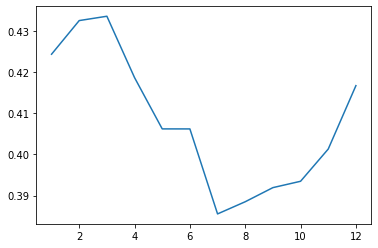

In [1008]:
month_portion_df = pd.DataFrame(early_70s.groupby('Month_name')['Office portion'].mean())
month_portion_df = month_portion_df.reset_index()
plt.plot(month_portion_df['Month_name'],month_portion_df['Office portion'])

In [1009]:
#Let's make a dictionary out of this
month_portion_dict = dict(zip(month_portion_df["Month_name"],month_portion_df['Office portion']))

#And then let's filter the full df to get just the 60s/early 70s rows that need imputing
sixties_df = census_df[census_df['Month']<year_begin]

In [1010]:
sixties_df['Office portion'] = [month_portion_dict[i.month] for i in sixties_df['Month']]
sixties_df['Office'] = sixties_df['Total commercial']*sixties_df['Office portion']
sixties_df['Other commercial'] = sixties_df['Total commercial'] - sixties_df['Office']

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [1011]:
census_df = census_df[census_df['Month']>=year_begin]
new_dfs = [sixties_df,census_df]
census_df = pd.concat(new_dfs)

Ok, very confusing...why are these values different from those in your "1964-2019 combined" file?

Note: this is probably because "Seasonally adjusted annual rate" is the actual value for the year. Yes! The US Census discussing their process of seasonal adjustment here: https://www.census.gov/construction/c30/seasonal_adj.html

And they note that, after adjusting seasonally, they multiply that month's value by 12 to get a sense of what the annual total would be if conditions that month prevailed for the entire year. 

So let's do that here: let's multiply the monthly values by 12. 

In [1012]:
census_df[['Office','Other commercial','Total commercial']] = census_df[['Office','Other commercial','Total commercial']]*12

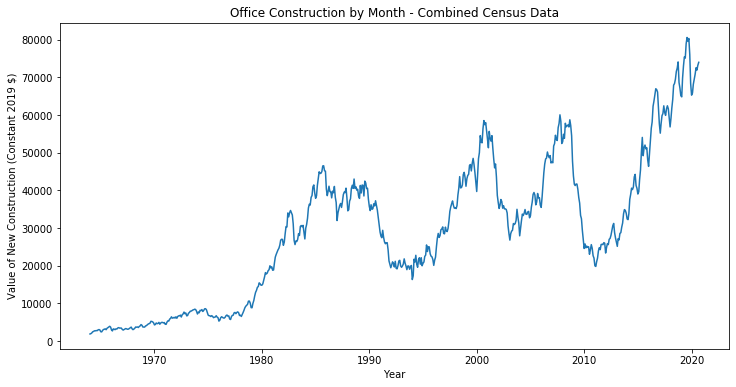

In [1013]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(census_df['Month'],census_df['Office'])

ax.set_ylabel('Value of New Construction (Constant 2019 $)')
ax.set_xlabel('Year')
ax.set_title('Office Construction by Month - Combined Census Data')
#ax.set_yscale('log')
plt.show()

#### Ok, now let's work with the pre-1964 data.

Ok, first thing's first, let's impute the 1915-1919 data using the other values in this dataset.

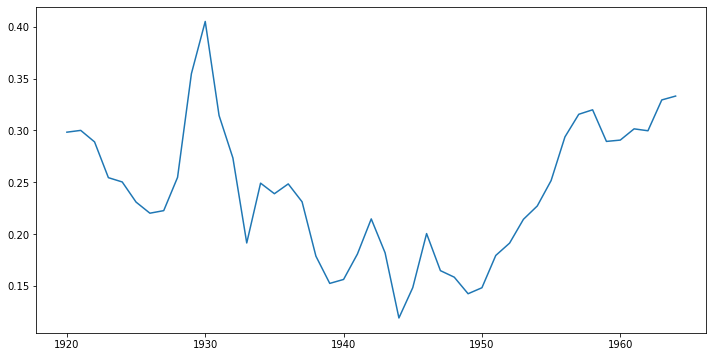

In [1014]:
Commerce_1915_1964['Non-Res, Non-Ind'] = Commerce_1915_1964['Total'] - Commerce_1915_1964['Industrial']
Commerce_1915_1964['Office portion'] = Commerce_1915_1964['Offices and Warehouses']/Commerce_1915_1964['Non-Res, Non-Ind']

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(Commerce_1915_1964['Year'],Commerce_1915_1964['Office portion'])
#ax.set_xlim([1920,1930])

Evidently, the percentage that office development represents of total non-residential, non-industrial development varies widely....but let's say we can take the firt half of the 1920s as representative. Let's average the office share of these years, and use it to compute the volume of office construction. There appears to be an inflection point in 1927, so we'll average the shares for the years 1920-1927.

In [1015]:
office_share = np.mean(Commerce_1915_1964[Commerce_1915_1964['Year']<1928]['Office portion'])

new_office_shares = []

for i in range(len(Commerce_1915_1964['Office portion'])):
    if math.isnan(Commerce_1915_1964['Office portion'][i]) == True:
        new_office_shares.append(office_share)
    else:
        new_office_shares.append(Commerce_1915_1964['Office portion'][i])
        
Commerce_1915_1964['Office portion'] = new_office_shares

new_office_vols = []

for i in range(len(Commerce_1915_1964['Offices and Warehouses'])):
    if math.isnan(Commerce_1915_1964['Offices and Warehouses'][i]) == True:
        new_office_volume = Commerce_1915_1964['Non-Res, Non-Ind'][i]*Commerce_1915_1964['Office portion'][i]
        new_office_vols.append(new_office_volume)
    else:
        new_office_vols.append(Commerce_1915_1964['Offices and Warehouses'][i])
        
Commerce_1915_1964['Offices and Warehouses'] = new_office_vols

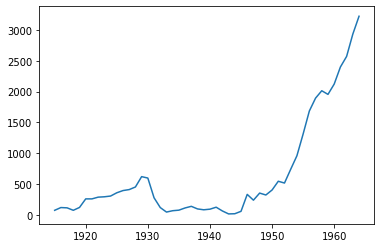

In [1016]:
plt.plot(Commerce_1915_1964['Year'],Commerce_1915_1964['Offices and Warehouses'])

Great! Ok, next step: update these values to 2019 dollars.

In [1017]:
#Let's first update the years to datetime format
commerce_dates = []

#Let's convert dates to datetime
format_str = '%m/%d/%Y'

for i in Commerce_1915_1964["Year"]:
    new_date = '1/1/'+str(i)
        
    new_date = datetime.strptime(new_date, format_str)
    commerce_dates.append(new_date)

Commerce_1915_1964["Month"] = commerce_dates

According to this inflation calculator on the BLS website, 1 dollar in 1957 is worth 9.12 in 2002 dollars. 

https://www.bls.gov/data/inflation_calculator.htm/

First, let's read in the historical dataset of the consumer price index, from the Bureau of Labor Statistics, over time 1913-2019. We can use this to calculate the present value of all the past values reported by the US Census and by the Commerce Department.

In [1018]:
CPI_BLS = pd.read_csv('CPI_BLS.csv')

See this explanation on how inflation between two eras is calculated: https://www.usinflationcalculator.com/inflation/inflation-vs-consumer-price-index-cpi-how-they-are-different/

"The CPI of January 2000 was 168.800 with the index for January 2010 listed as 216.687...To make the calculations, we take the more recent CPI, subtract the oldest CPI, and then divide by the oldest CPI. Using our numbers shown above, it would be 216.687, minus 168.800, divided by 168.800. This equals .2837."

Let's do this on a month-by-month basis. So, for each month's value in the census_df, we'll re-calculate its 2002 value. In order to this, let's create simple dictionary mapping the months' number values to their names.

In [1019]:
month_names = list(CPI_BLS.columns)[1:-3]
month_dict = dict(zip(list(range(1,13)),month_names))

In [1020]:
#Let's write a formula to calculate the new value of a dollar amount based on the inflation/CPI between two eras:

def calculate_new_value(old_val,old_month,old_year,new_month,new_year):
    old_cpi = float(CPI_BLS[CPI_BLS['Year']==old_year][old_month])
    new_cpi = float(CPI_BLS[CPI_BLS['Year']==new_year][new_month])
    
    inf_rate = (new_cpi-old_cpi)/old_cpi
    
    new_val = old_val*(1+inf_rate)
    
    return new_val

In [1021]:
#Let's do this for every value in census_df

new_office_vals = []

for i in range(len(census_df)-9): #Let's do this up to 2020. We won't re-convert 2020 values
    row = census_df.iloc[i]
    old_month = month_dict[row['Month'].month]
    old_year = row['Month'].year
    old_val = float(row['Office'])
    
    new_month = 'Jan'
    new_year = 2019
    
    new_val = calculate_new_value(old_val,old_month,old_year,new_month,new_year)
    
    new_office_vals.append(new_val)

new_office_vals.extend(list(census_df['Office'][-9:]))

new_com_vals = []

for i in range(len(census_df)-9): #Let's do this up to 2020. We won't re-convert 2020 values
    row = census_df.iloc[i]
    old_month = month_dict[row['Month'].month]
    old_year = row['Month'].year
    old_val = float(row['Other commercial'])
    
    new_month = 'Jan'
    new_year = 2019
    
    new_val = calculate_new_value(old_val,old_month,old_year,new_month,new_year)
    
    new_com_vals.append(new_val)

new_com_vals.extend(list(census_df['Other commercial'][-9:]))

new_tot_vals = []

for i in range(len(census_df)-9): #Let's do this up to 2020. We won't re-convert 2020 values
    row = census_df.iloc[i]
    old_month = month_dict[row['Month'].month]
    old_year = row['Month'].year
    old_val = float(row['Total commercial'])
    
    new_month = 'Jan'
    new_year = 2019
    
    new_val = calculate_new_value(old_val,old_month,old_year,new_month,new_year)
    
    new_tot_vals.append(new_val)

new_tot_vals.extend(list(census_df['Total commercial'][-9:]))

#Update all the fields in the dataframe
census_df['Office'] = new_office_vals
census_df['Other commercial'] = new_com_vals
census_df['Total commercial'] = new_tot_vals



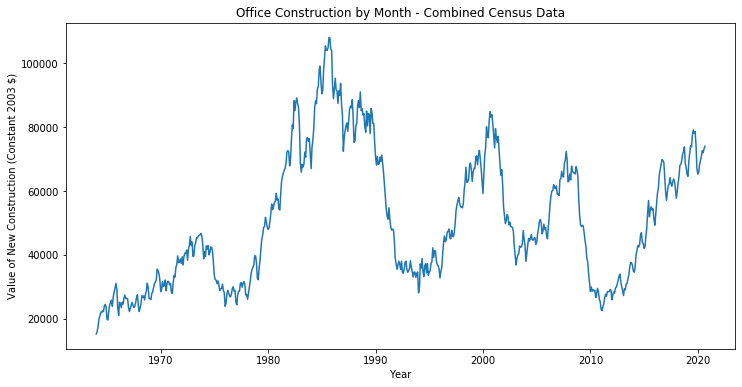

In [1022]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(census_df['Month'],census_df['Office'])

ax.set_ylabel('Value of New Construction (Constant 2003 $)')
ax.set_xlabel('Year')
ax.set_title('Office Construction by Month - Combined Census Data')
#ax.set_yscale('log')
plt.show()

Ok! The above looks right, and makes more sense: the 1980s is clearly the most intense boom-bust sequence of the post-war period, and the 1970s boom-bust is now visible, which it was not before.

Now let's do the same for the Commerce dataset.

In [1023]:
Commerce_1915_1964.head()

,Year,Offices and Warehouses,"Stores, Restaurants and Garages",Industrial,Total,"Non-Res, Non-Ind",Office portion,Month
0,1915,72.535038,NaN,197,478,281,0.258132,1915-01-01
1,1916,117.191840,NaN,262,716,454,0.258132,1916-01-01
2,1917,112.545468,NaN,364,800,436,0.258132,1917-01-01
3,1918,72.793169,NaN,449,731,282,0.258132,1918-01-01
4,1919,118.998763,NaN,621,1082,461,0.258132,1919-01-01


In [1024]:
#Let's do this for every value in Commerce_df....though maybe we'll only do it for offices now, since we don't care about hte others

new_office_vals = []

for i in range(len(Commerce_1915_1964)): #Let's do this up to 2020. We won't re-convert 2020 values
    row = Commerce_1915_1964.iloc[i]
    old_month = month_dict[row['Month'].month]
    old_year = row['Month'].year
    old_val = float(row['Offices and Warehouses'])
    
    new_month = 'Jan'
    new_year = 2019
    
    new_val = calculate_new_value(old_val,old_month,old_year,new_month,new_year)
    
    new_office_vals.append(new_val)

#Update all the fields in the dataframe
Commerce_1915_1964['Offices and Warehouses'] = new_office_vals

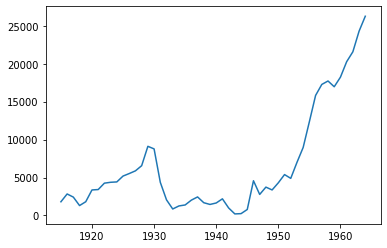

In [1025]:
plt.plot(Commerce_1915_1964['Year'],Commerce_1915_1964["Offices and Warehouses"])

Ok! Commerce_1920_1964 looks like it will sync up fairly well with this df. The next step is now to convert that df's "Year" column to datetime, so that we can combine the two. We'll then weave in the month-by-month BLS data (which we will probably have to convert into annualized values). From there, we can decide whether we want to add in monthly/seasonal variation for those years for which we only have annual data.

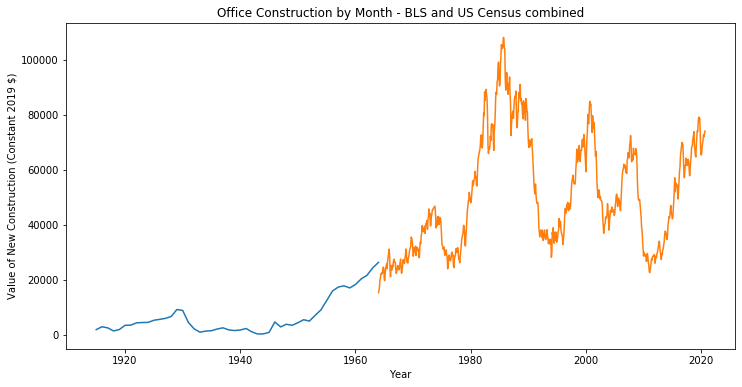

In [1026]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(Commerce_1915_1964['Month'],Commerce_1915_1964['Offices and Warehouses'])
ax.plot(census_df['Month'],census_df['Office'])

ax.set_ylabel('Value of New Construction (Constant 2019 $)')
ax.set_xlabel('Year')
ax.set_title('Office Construction by Month - BLS and US Census combined')
#ax.set_yscale('log')
plt.show()


Nice! They seem to match up pretty closely. The Commerce data includes "warehouses" as well in its office data, so that might explain why the 1964 value in Commerce looks a little high....we could either adjust it, or just leave it in since it doesn't seem to be off by much. 

The one concern is the 1920s boom looks pretty muted in here - perhaps we will also have to adjust for inflation in the way we did in the other datasets?

Now let's look at the BLS data.

In [1027]:
BLS_1939_1956 = BLS_1939_1956[['Month','Year','Date','Office and Warehouse','Stores, restaurants, garages']]

In [1028]:
#Let's convert dates to datetime
format_str = '%m/%d/%Y'

new_1939_1956_dates = []
for i in BLS_1939_1956["Date"]:
    new_date = i[:-2]+'19'+i[-2]+i[-1]
        
    new_date = datetime.strptime(new_date, format_str)
    new_1939_1956_dates.append(new_date)

BLS_1939_1956["Date"] = new_1939_1956_dates

In [1029]:
BLS_1939_1956['Office and Warehouse'] = BLS_1939_1956['Office and Warehouse'].astype(float)

Let's also convert these values to 2020 dollars. 1 dollar in 1947 is worth 8.25 in 2003, according to the BLS website.

In [1030]:
inf_index_1947 = 11.71

In [1031]:
BLS_1939_1956['Office and Warehouse'] = BLS_1939_1956['Office and Warehouse']*inf_index_1947
BLS_1939_1956['Stores, restaurants, garages'] = BLS_1939_1956['Stores, restaurants, garages']*inf_index_1947

In [1032]:
#Let's also multiply values by 12 to get the annualized value
BLS_1939_1956['Office and Warehouse'] = BLS_1939_1956['Office and Warehouse']*12
BLS_1939_1956['Stores, restaurants, garages'] = BLS_1939_1956['Stores, restaurants, garages']*12

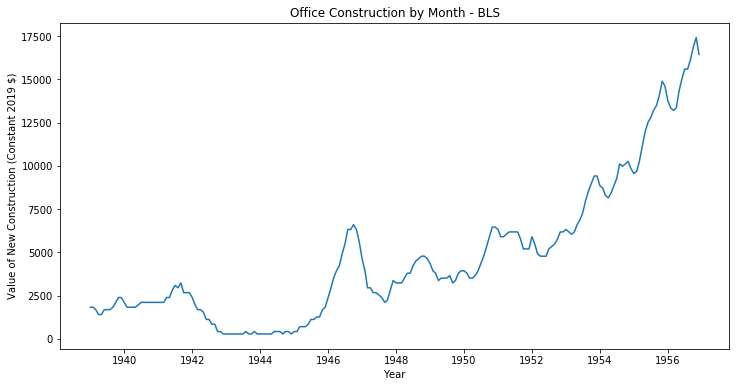

In [1033]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(BLS_1939_1956['Date'],BLS_1939_1956['Office and Warehouse'])

ax.set_ylabel('Value of New Construction (Constant 2019 $)')
ax.set_xlabel('Year')
ax.set_title('Office Construction by Month - BLS')
plt.show()


Ok, now let's combine this BLS dataframe with the Commerce data frame - we'll override the years in the Commerce data.

In [1034]:
#Let's first make the column names match up
Commerce_1915_1964 = Commerce_1915_1964.rename(columns={'Offices and Warehouses':'Office and Warehouse',
                                                       'Stores, Restaurants and Garages':'Stores, restaurants, garages',
                                                       'Month':'Date'})

Commerce_1915_1964 = Commerce_1915_1964.drop(['Industrial','Total','Non-Res, Non-Ind','Office portion'], axis=1)
BLS_1939_1956 = BLS_1939_1956.drop(['Month'], axis=1)

#And then reorder the columns so that they are in the same order
BLS_1939_1956 = BLS_1939_1956[list(Commerce_1915_1964.columns)]

Now we're ready to merge.

In [1037]:
date_min_BLS = np.min(BLS_1939_1956['Date'])
date_max_BLS = np.max(BLS_1939_1956['Date'])

In [1039]:
commerce_early = Commerce_1915_1964[Commerce_1915_1964['Date']<date_min_BLS]
commerce_late = Commerce_1915_1964[Commerce_1915_1964['Date']>date_max_BLS]

new_frames = [commerce_early,BLS_1939_1956,commerce_late]

office_early = pd.concat(new_frames)
office_early = office_early.reset_index()
office_early = office_early.drop(['index'], axis=1)

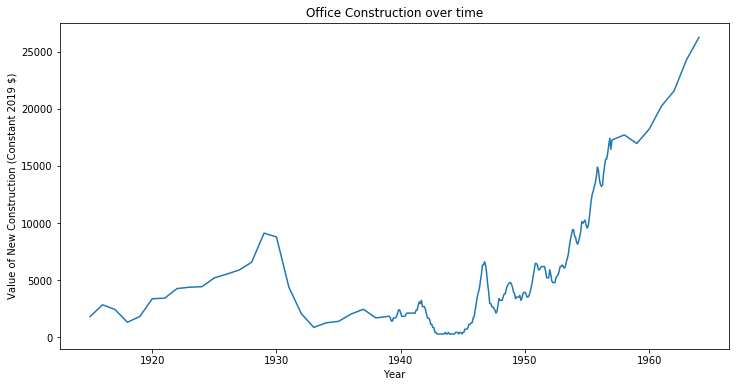

In [1040]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(office_early['Date'],office_early['Office and Warehouse'])

ax.set_ylabel('Value of New Construction (Constant 2019 $)')
ax.set_xlabel('Year')
ax.set_title('Office Construction over time')
plt.show()


Cool! It looks a little wonky without monthly variation in some of the years....you should probably impute this. But for now, let's combine it with the full census dataset.

In [1041]:
office_late = census_df[['Month','Office']]
office_early = office_early[['Date','Office and Warehouse']]

office_early = office_early.rename(columns={'Date':'Month','Office and Warehouse':'Office'})

office_late = office_late[office_late['Month']>np.max(office_early['Month'])]

office_dfs = [office_early,office_late]
office_df = pd.concat(office_dfs)
office_df = office_df.reset_index()
office_df = office_df.drop(['index'], axis=1)

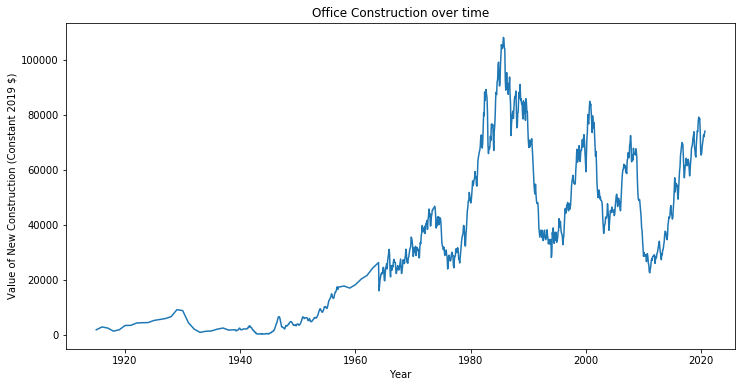

In [1042]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(office_df['Month'],office_df['Office'])

ax.set_ylabel('Value of New Construction (Constant 2019 $)')
ax.set_xlabel('Year')
ax.set_title('Office Construction over time')
plt.show()


Note: It may be worthwhile to weight this by population, since the US population was considerably smaller in 1920.

In [1043]:
from scipy.stats import linregress
US_pop = pd.read_csv("US_Population.csv")
US_pop['Population'] = US_pop['Population'].str.replace(',', '').astype(float)

Let's us this data on US population every decade to interpolate and get US Population for every value in the time series, and then we'll weight by that.

In [1044]:
#Let's compute the regression line for this one variable
x = US_pop['Year']
y = US_pop['Population']
slope, intercept, r_value, p_value, std_err = linregress(x, y)  

r_value

0.9916580123307116

Ok! So a simple linear regression gets a very good fit of US population over time.

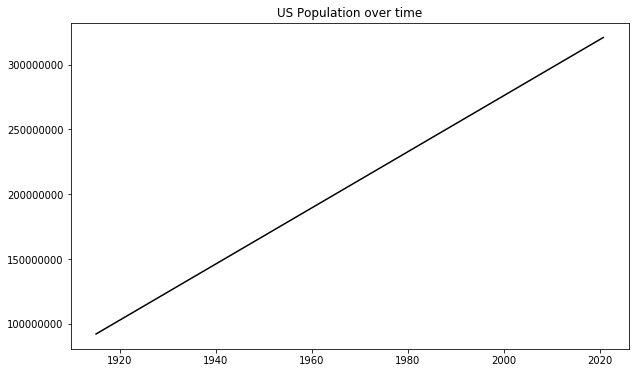

In [1045]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

x = np.array([float(office_df['Month'][i].year)+float(office_df['Month'][i].month)/12 for i in range(len(office_df))])
pop_interpolated = slope*x+intercept
#And then let's add the regression line to the plot
ax.plot(x,pop_interpolated,c= "k")
ax.ticklabel_format(useOffset=False, style='plain')
ax.set_title("US Population over time")
plt.show()


In [1052]:
office_df['Population'] = pop_interpolated
office_df['Office_per_cap'] = office_df['Office']/(office_df['Population']/1000000)

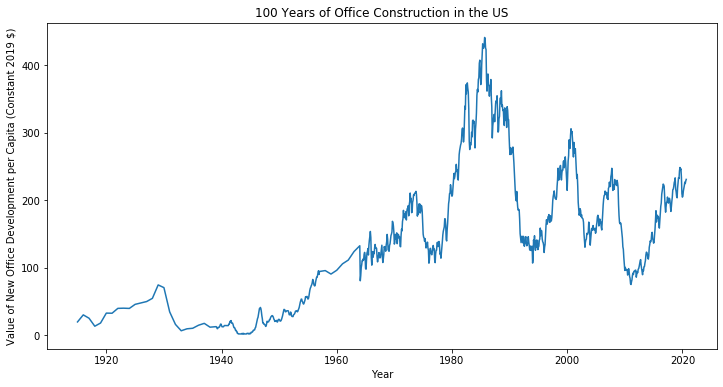

In [1053]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(office_df['Month'],office_df['Office_per_cap'])

ax.set_ylabel('Value of New Office Development per Capita (Constant 2019 $)')
ax.set_xlabel('Year')
ax.set_title('100 Years of Office Construction in the US')
plt.show()


This is odd...the 1920s boom is considerably less pronounced when you use the original, unadjusted data from Commerce instead of the data converted into 1957 dollars. Perhaps you are better off using that.

Yes, in fact the numbers seem quite different....if you use the adjusted 1957 data, the figures are considerably higher. You're better off using that.

Note: the 1920s would likely be considerably more evident if you weighted by GDP/GNP rather than population, since GDP really took off after the war. 

Ok, some things to fix: 

 - Ideally, get data from before 1920, so you can have a better sense of the runup to the 1929/1930 collapse. This may exist somewhere in the CFC, or Architectural forum....check! 

 - Confirm: is the 1920s data correct? The 1920s boom-bust certainly look pretty muted by comparison with the post-war cycles. If this is correct, you will have to contextualize this somehow with a zoom-in on the 1920s
 
 - The transition from the Commerce/BLS data to the census data is abrupt - probably because warehouse is included in the Commerce/BLS data. Perhaps you should adjust these esimates downwards.
 
 - You should imput the monthly/seasonal variation for eras in which that does not exist. It would make this graph look nicer. 

How to impute the monthly variation from 1957-1963? Look at the secular trend from 1945-1956, and again from 1964-1972.

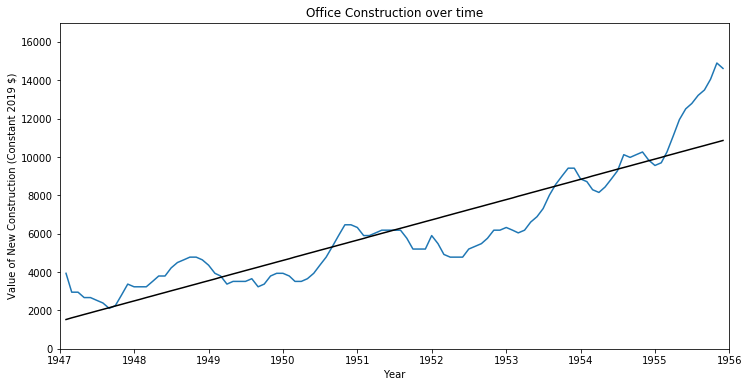

In [713]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

date_min = '01/01/1947'
date_max = '01/01/1956'

date_min = datetime.strptime(date_min, format_str)
date_max = datetime.strptime(date_max, format_str)

interp_df = office_df[office_df['Month']<date_max]
interp_df = interp_df[interp_df['Month']>date_min]
interp_df = interp_df.reset_index()
interp_df = interp_df.drop(['index'], axis=1)

ax.plot(interp_df['Month'],interp_df['Office'])

x = np.array([float(interp_df['Month'][i].year)+float(interp_df['Month'][i].month)/12 for i in range(len(interp_df))])
y = interp_df['Office']

slope, intercept, r_value, p_value, std_err = linregress(x, y)  

office_interpolated = slope*x+intercept
#And then let's add the regression line to the plot
ax.plot(interp_df['Month'],office_interpolated,c= "k")

ax.set_ylabel('Value of New Construction (Constant 2019 $)')
ax.set_xlabel('Year')
ax.set_title('Office Construction over time')
ax.set_xlim([date_min,date_max])
ax.set_ylim([0,17000])
plt.show()

In [ ]:
import numpy.polynomial.polynomial as poly

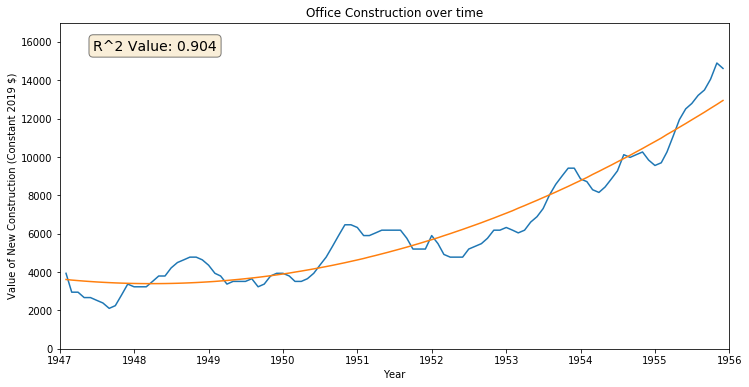

In [729]:
coefs = poly.polyfit(x, y, 2)
ffit = poly.polyval(x, coefs)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.plot(interp_df['Month'],interp_df['Office'])
ax.plot(interp_df['Month'], ffit)

r2_score = r2_score(ffit,y)

#Let's display the R^2 value
disp_r_value = round(r2_score,3)
display_text = "R^2 Value: "+ str(disp_r_value)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.05, 0.95, display_text, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_ylabel('Value of New Construction (Constant 2019 $)')
ax.set_xlabel('Year')
ax.set_title('Office Construction over time')
ax.set_xlim([date_min,date_max])
ax.set_ylim([0,17000])
plt.show()


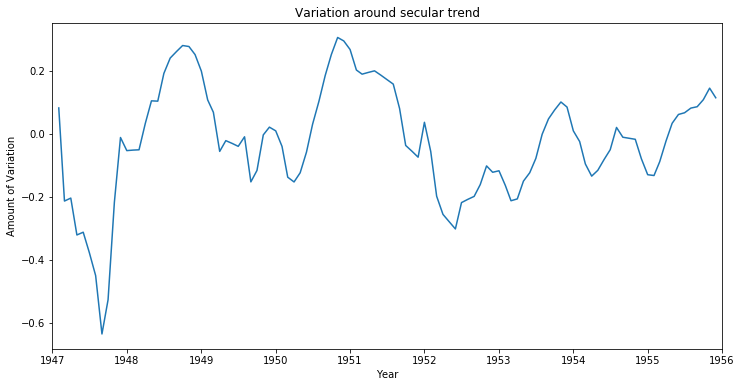

In [737]:
seasonal_variation = (y - ffit)/y

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.plot(interp_df['Month'],seasonal_variation)

ax.set_ylabel('Amount of Variation')
ax.set_xlabel('Year')
ax.set_title('Variation around secular trend')
ax.set_xlim([date_min,date_max])
#ax.set_ylim([0,17000])
plt.show()


There's evidently not much in the way of seasonal variation - there instead appears to be some other type of cycle of 1-2 years in duration.

Now find the exponential line that most closely matches this, and then track the variation from that line as a way to gauge seasonality.

In [738]:
variation_df = pd.DataFrame(list(zip(interp_df['Month'],seasonal_variation)),columns=['Month','Variation'])
variation_df['Month_name'] = [i.month for i in variation_df['Month']]

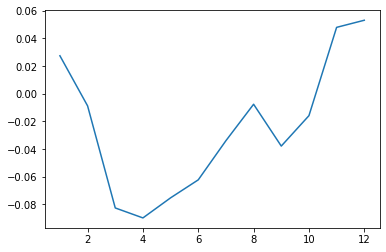

In [739]:
monthly_variation_df = pd.DataFrame(variation_df.groupby('Month_name')['Variation'].mean())
monthly_variation_df = monthly_variation_df.reset_index()
plt.plot(monthly_variation_df['Month_name'],monthly_variation_df['Variation'])


Ok, there is what appears to be somewhat of a seasonal/sinewave trend....It's certainly not completely random.

In [766]:
monthly_variation_dict = dict(zip(monthly_variation_df['Month_name'],monthly_variation_df['Variation']))

In [756]:
#Let's get just the years that do not have data for individual months
office_df['Year'] = [i.year for i in office_df['Month']]
single_years = list(office_df['Year'].value_counts()[office_df['Year'].value_counts()<2].index)
single_years.sort()

In [772]:
format_str = '%m/%d/%Y'

new_dates = []
new_office_vals = []
for year in single_years:
    office_year = office_df[office_df['Year']==year]
    year_office = float(office_year['Office'])
    
    for month in list(range(1,13)):
        if len(str(month))<2:
            new_date = '0'+str(month)+'/01/'+str(year)
        else:
            new_date = str(month)+'/01/'+str(year)
    
        new_date = datetime.strptime(new_date, format_str)
        new_dates.append(new_date)
        
        month_var = monthly_variation_dict[month]
        office_val = year_office + year_office*month_var
        new_office_vals.append(office_val)

imputed_office_df = pd.DataFrame(list(zip(new_dates,new_office_vals)),columns=['Month','Office'])

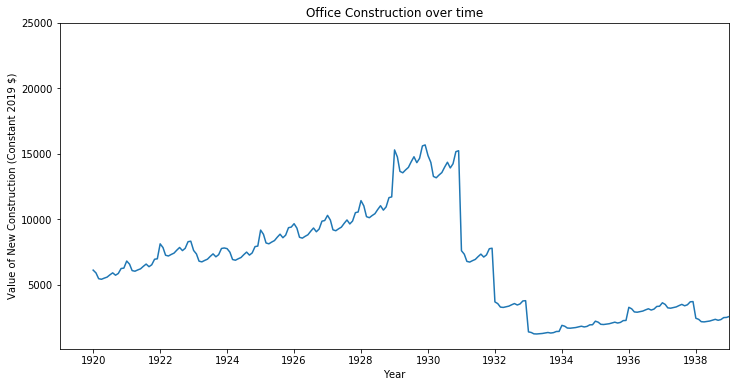

In [775]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

date_min = '01/01/1919'
date_max = '01/01/1939'

date_min = datetime.strptime(date_min, format_str)
date_max = datetime.strptime(date_max, format_str)

interp_df = imputed_office_df[imputed_office_df['Month']<date_max]
interp_df = imputed_office_df[imputed_office_df['Month']>date_min]
interp_df = interp_df.reset_index()
interp_df = interp_df.drop(['index'], axis=1)

ax.plot(interp_df['Month'],interp_df['Office'])

ax.set_ylabel('Value of New Construction (Constant 2019 $)')
ax.set_xlabel('Year')
ax.set_title('Office Construction over time')
ax.set_xlim([date_min,date_max])
#ax.set_ylim([0,17000])
plt.show()

In [797]:
office_df_full_months = office_df[~office_df['Year'].isin(single_years)][['Month','Office']]
office_df_full_months = office_df_full_months.reset_index()
office_df_full_months = office_df_full_months.drop(['index'], axis=1)

new_office_dfs = [imputed_office_df,office_df_full_months]
new_office_df = pd.concat(new_office_dfs)
new_office_df = new_office_df.reset_index()
new_office_df = new_office_df.drop(['index'], axis=1)

new_office_df = new_office_df.sort_values(by='Month',ascending=True)

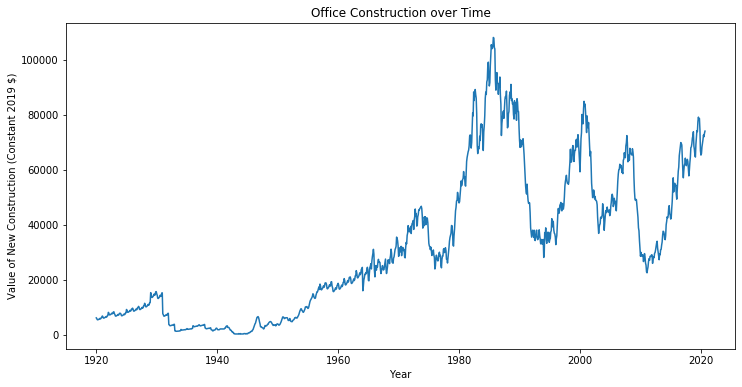

In [798]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(new_office_df['Month'],new_office_df['Office'])

ax.set_ylabel('Value of New Construction (Constant 2019 $)')
ax.set_xlabel('Year')
ax.set_title('Office Construction over Time')
plt.show()


In [799]:
#Let's add population and office per capita back in
#Let's compute the regression line for this one variable
x = US_pop['Year']
y = US_pop['Population']
slope, intercept, r_value, p_value, std_err = linregress(x, y)  

x = np.array([float(new_office_df['Month'][i].year)+float(new_office_df['Month'][i].month)/12 for i in range(len(new_office_df))])
pop_interpolated = slope*x+intercept
new_office_df['Population'] = pop_interpolated
new_office_df['Office_per_cap'] = new_office_df['Office']/(new_office_df['Population']/1000000)

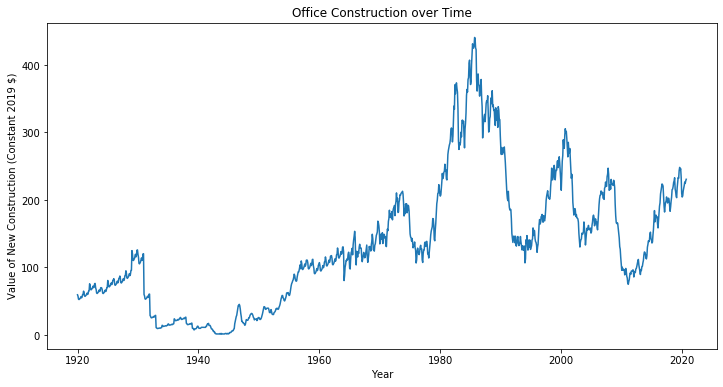

In [800]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(new_office_df['Month'],new_office_df['Office_per_cap'])

ax.set_ylabel('Value of New Construction (Constant 2019 $)')
ax.set_xlabel('Year')
ax.set_title('Office Construction over Time')
plt.show()

Note that the imputed seasonal variation looks not great....there is likely a more than just a seasonal variation....perhaps you should have it be more random. BETTER YET: Have the variation draw from a distribution.

Also note: you really do need values from before 1920....it would make this graph much more compelling. And then label the major financial crises: 1929, 1973-5, 1989/1990, 2001, 2008.

Let's get the mean and standard deviation of the variation around the secular trend from 1939-1956.

In [846]:
var_mu = np.mean(variation_df['Variation'])
var_sigma = np.std(variation_df['Variation'])/3

In [847]:
format_str = '%m/%d/%Y'

new_dates = []
new_office_vals = []
for year in single_years:
    office_year = office_df[office_df['Year']==year]
    year_office = float(office_year['Office'])
    
    for month in list(range(1,13)):
        if len(str(month))<2:
            new_date = '0'+str(month)+'/01/'+str(year)
        else:
            new_date = str(month)+'/01/'+str(year)
    
        new_date = datetime.strptime(new_date, format_str)
        new_dates.append(new_date)
        
        month_var = float(np.random.normal(var_mu, var_sigma, 1))
        office_val = year_office + year_office*month_var
        new_office_vals.append(office_val)

imputed_office_df = pd.DataFrame(list(zip(new_dates,new_office_vals)),columns=['Month','Office'])

In [848]:
office_df_full_months = office_df[~office_df['Year'].isin(single_years)][['Month','Office']]
office_df_full_months = office_df_full_months.reset_index()
office_df_full_months = office_df_full_months.drop(['index'], axis=1)

new_office_dfs = [imputed_office_df,office_df_full_months]
new_office_df = pd.concat(new_office_dfs)
new_office_df = new_office_df.reset_index()
new_office_df = new_office_df.drop(['index'], axis=1)

new_office_df = new_office_df.sort_values(by='Month',ascending=True)

In [849]:
#Let's add population and office per capita back in
#Let's compute the regression line for this one variable
x = US_pop['Year']
y = US_pop['Population']
slope, intercept, r_value, p_value, std_err = linregress(x, y)  

x = np.array([float(new_office_df['Month'][i].year)+float(new_office_df['Month'][i].month)/12 for i in range(len(new_office_df))])
pop_interpolated = slope*x+intercept
new_office_df['Population'] = pop_interpolated
new_office_df['Office_per_cap'] = new_office_df['Office']/(new_office_df['Population']/1000000)

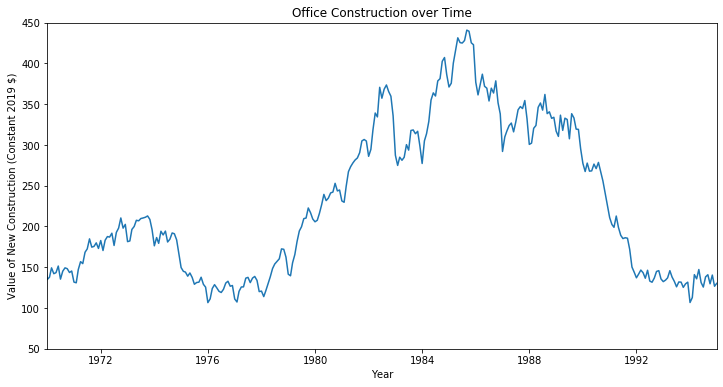

In [861]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(new_office_df['Month'],new_office_df['Office_per_cap'])

ax.set_ylabel('Value of New Construction (Constant 2019 $)')
ax.set_xlabel('Year')
ax.set_title('Office Construction over Time')

year_begin = datetime.strptime("01/01/1970", format_str)
year_end = datetime.strptime("01/01/1995", format_str)

ax.set_xlim([year_begin,year_end])
ax.set_ylim([50,450])

plt.show()